<a href="https://colab.research.google.com/github/travisdriver/siw22_demo/blob/main/gtsfm_siw22_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3rd Space Imaging Workshop SfM Demo

# Set up Python 3.8 Environment
Adapted from https://gist.github.com/ngrislain/c3ba6f687c64ce31adc6b0dff1b26d6a

In [ ]:
!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y jupyter
!conda install -q -y google-colab -c conda-forge
!python -m ipykernel install --name "py38" --user

In [ ]:
# Reload the web page and execute this cell
import sys
print("User Current Version:-", sys.version)
!conda --version

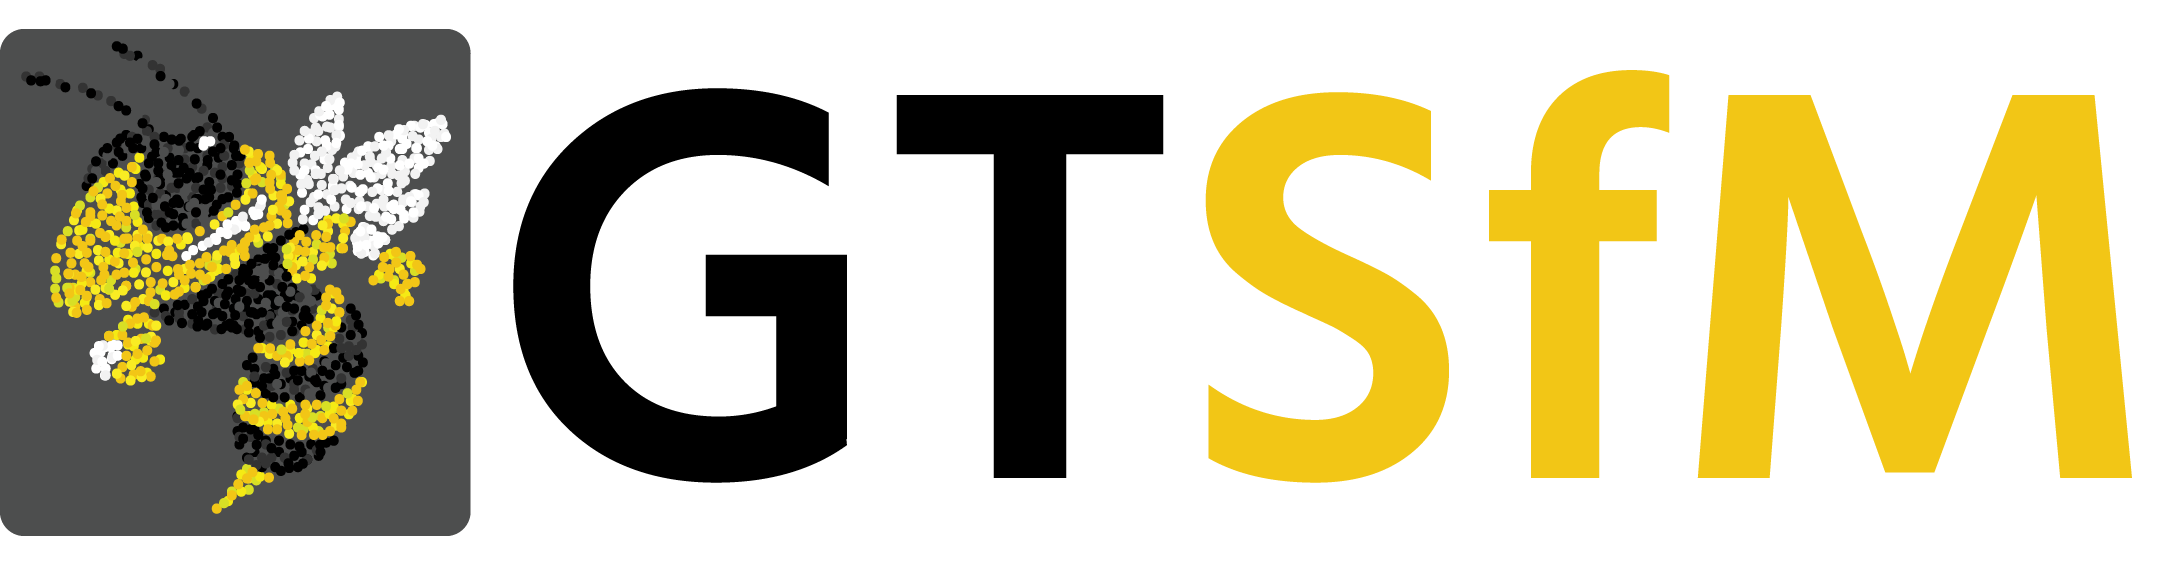

Georgia Tech Structure-from-Motion (GTSfM) is an end-to-end SfM pipeline based on [GTSAM](https://gtsam.org/). 
GTSfM was designed from the ground-up to natively support parallel computation using [Dask](https://www.dask.org/).

# Clone GTSfM repository and set up environment

In [3]:
!git clone --quiet --recursive https://github.com/borglab/gtsfm.git
%cd /content/gtsfm

/content/gtsfm


In [ ]:
%%shell
conda env update --file environment_linux.yml

Before running reconstruction, if you intend to use modules with pre-trained weights, such as SuperPoint, SuperGlue, or PatchmatchNet, please first run:

In [ ]:
!./download_model_weights.sh

In [ ]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
conda activate gtsfm-v1
python --version
pip install -e .

# Download Image Sequences


`2011212_opnav_022`: Optical navigation phase from the Dawn mission to 4 Vesta

`2011205_rc3`: Rotation Characterization 3 (RC3) phase from the Dawn mission to 4 Vesta

`rc4_north_001`: Rotation Characterization 4 (RC4) phase from the Dawn mission to 1 Ceres

More sequences will be added in the future.

In [7]:
# ! cd tests/data && wget https://www.dropbox.com/s/af9wloxsb09g50g/2011212_opnav_022.zip && unzip 2011212_opnav_022.zip

In [ ]:
! cd tests/data && wget https://www.dropbox.com/s/q02mgq1unbw068t/2011205_rc3.zip && unzip 2011205_rc3.zip

In [9]:
# ! cd tests/data && wget https://www.dropbox.com/s/cm6pehpsud5b6xa/rc4_north_001.zip && unzip rc4_north_001.zip

## Visualize image sequence

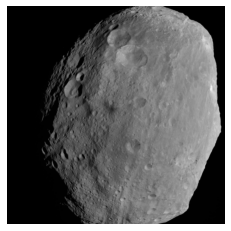

In [10]:
import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

# Set path to image sequence of interest.
PATH_TO_SEQUENCE = "/content/gtsfm/tests/data/2011205_rc3/images/"

# Generate sequence animation.
img_paths = sorted([os.path.join(PATH_TO_SEQUENCE, _fn) for _fn in os.listdir(PATH_TO_SEQUENCE) if _fn.endswith(".png")])
frames = [] # for storing the generated images
fig = plt.figure()
plt.axis('off')
for path in img_paths:
  _img = plt.imread(path)
  frames.append([plt.imshow(_img, animated=True)])
ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True, repeat_delay=1000)

from IPython.display import HTML
HTML(ani.to_jshtml())

# Run GTSfM on image sequence

Best results are achieved by using the deep front-end, i.e., `--config_name deep_frontend_astrovision.yaml`, and using exhaustive matching, i.e., `--matching_regime exhaustive`. 

Please refer to the [GTSfM GitHub page](https://github.com/borglab/gtsfm) for more details. We're always open to [contributions](https://github.com/borglab/gtsfm/blob/master/CONTRIBUTING.md) as well! 

In [ ]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
conda activate gtsfm-v1
python gtsfm/runner/run_scene_optimizer_astrovision.py \
--data_dir tests/data/2011205_rc3 --matching_regime exhaustive \
--config_name deep_front_end_astrovision.yaml --max_resolution 1024 --share_intrinsics

# Visualize reconstruction with `visu3d`

_Disclaimer_: `visu3d` (and some of its dependencies) is under active development. If you come across an error, feel free to submit a PR with a fix or an issue explaining the error.

In [ ]:
%pip install numpy>=1.21 lark einops plotly etils[ecolab] jax[cpu] tf-nightly tfds-nightly sunds
!cd thirdparty && git clone https://github.com/google-research/visu3d.git
!cd thirdparty/visu3d && git checkout 8ecf9d95cf7f085b0245b07422ccda007937a5c6  # this commit seems to be working but could break in the future
!cd thirdparty && git clone https://github.com/google-research/dataclass_array.git

In [13]:
import sys
sys.path.append("/usr/local/lib/python3.8/site-packages")

from etils.ecolab.lazy_imports import *

from thirdparty.colmap.scripts.python.read_write_model import read_model
sys.path.append("thirdparty/dataclass_array/")
sys.path.append("thirdparty/visu3d/")
import thirdparty.visu3d.visu3d as v3d

ecolab.auto_plot_array()  # Display np.array as images/video
tnp.experimental_enable_numpy_behavior()  # Activate TF numpy behavior

cameras, images, points3d = read_model("results/ba_output")
pcd = np.array([_p3d.xyz for _p3d in points3d.values()])
rgb = np.array([_p3d.rgb for _p3d in points3d.values()])
cams = []
for _i in images.values():
    _c = cameras[_i.camera_id]
    R = _i.qvec2rotmat()
    t = (-R.T @ _i.tvec.reshape((3, 1))).flatten()
    cams.append(
        v3d.Camera(
             spec=v3d.PinholeCamera.from_focal(resolution=(_c.height, _c.width), 
             focal_in_px=_c.params[0]),
             world_from_cam=v3d.Transform(R=R.T, t=t),
        )
    )

point_cloud = v3d.Point3d(
    p=pcd,
    rgb=rgb,
)
v3d.make_fig([*cams, point_cloud,])

Display big np/tf/jax arrays as image for nicer IPython display
Detected model format: '.txt'
